### Imports

In [35]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

PLOTS = True

### Load in Data and Normalize Scales

In [36]:
data = pd.read_csv("data/daily_ret_clean.csv").set_index("date")
logdata = np.log(data + 1) # Get log returns
stock_names = data.columns

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(logdata)

### Perform PCA

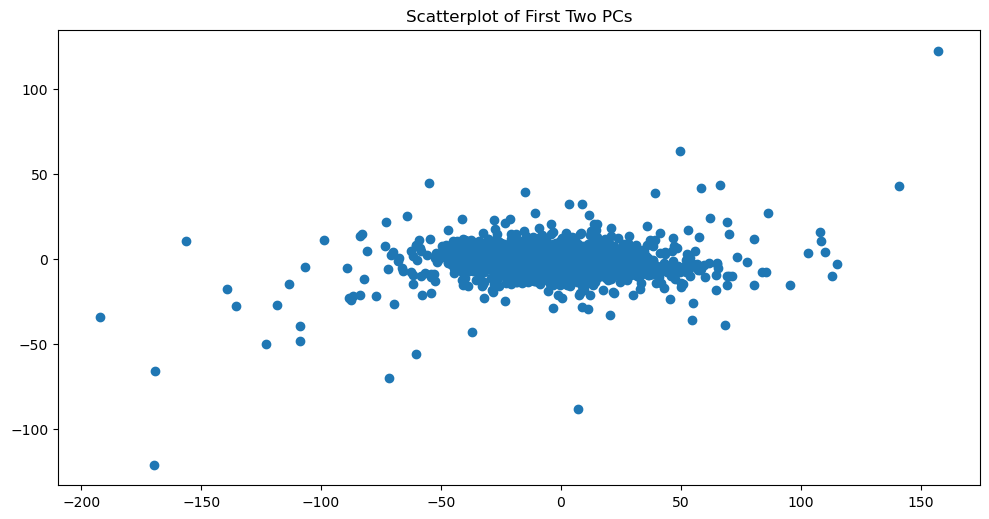

In [69]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(scaled)
combined = np.concatenate([pca.components_, pca.explained_variance_ratio_.reshape(-1,1)], axis=1)
components = pd.DataFrame(
    pca.components_,
    columns=list(stock_names),# + ["Explained Var"],
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

if PLOTS:
    plt.figure(figsize=(10,10))
    
    plt.subplot(2,1,2)
    plt.title("Scatterplot of First Two PCs")
    plt.scatter(X_pca[:,0], X_pca[:, 1])

    plt.tight_layout()

### Portfolio Weighting
Your component mixtures are your portfolio weights

In [77]:
# We performed PCA on scaled returns so we need to scale our weights as well

weights = components/logdata.std(axis=0)
factor_returns = weights.dot(logdata.T) / len(stock_names)
factor_returns

date,2000-01-03,2000-01-04,2000-01-05,2000-01-06,2000-01-07,2000-01-10,2000-01-11,2000-01-12,2000-01-13,2000-01-14,...,2023-12-15,2023-12-18,2023-12-19,2023-12-20,2023-12-21,2023-12-22,2023-12-26,2023-12-27,2023-12-28,2023-12-29
PC1,-0.014514,-0.025161,0.007616,0.003843,0.020672,0.006946,-0.011785,-0.002831,0.012911,0.003964,...,-0.009371,0.000204,0.013813,-0.016484,0.013814,0.005481,0.008807,0.000703,-0.000095,-0.007679
PC2,0.009502,0.008106,0.005156,0.004995,0.001734,-0.000536,-0.003495,-0.001046,-0.004207,-0.001945,...,0.000158,0.001202,0.000329,-0.000395,-0.000092,0.000308,-0.001723,0.001414,-0.002165,0.003322
PC3,0.009079,-0.011260,-0.003125,-0.010011,0.007348,0.014602,-0.004113,-0.002033,0.004722,0.009822,...,0.003996,0.001342,-0.001224,-0.000620,0.003186,-0.000330,-0.000943,0.000122,-0.000568,0.002615
PC4,-0.005140,-0.005783,0.005069,-0.001148,0.009913,0.002433,-0.001419,0.000286,0.000642,-0.001648,...,-0.003800,0.001279,-0.002407,-0.004509,-0.000499,0.000890,-0.002075,0.000709,0.003451,0.003111
PC5,-0.007391,0.000561,0.005980,0.007112,0.003001,-0.007215,0.003860,-0.000205,0.001664,-0.002918,...,-0.000899,0.003459,-0.000142,-0.002335,0.000241,-0.000142,-0.000222,-0.001430,-0.000513,0.001963


In [78]:
market_returns = np.mean(logdata, axis=1)
factor_returns.iloc[0].corr(market_returns)

0.9959748382831709

### Finding the Coefficients for Each Factor

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Sample data
X = factor_returns.T
Y = logdata * 5000

# Create a multi-output regression model
model = LinearRegression()
model.fit(X, Y)

coefs = pd.DataFrame(model.coef_, index=data.columns, columns=X.columns)
coefs["alpha"] = model.intercept_

coefs

,PC1,PC2,PC3,PC4,PC5,alpha
10026,3387.580913,-575.241423,-2338.122567,2772.047369,-161.911472,0.811356
10032,6003.812141,-4257.182796,12043.244562,-689.031325,-6971.595923,0.182228
10044,1521.509296,2196.166170,255.038575,-1054.631028,-669.674124,0.635658
10065,3397.354862,848.111746,2609.548079,1595.582223,423.585797,-0.184320
10104,4102.286109,-2116.110809,9458.352728,5834.147764,-2707.424876,-0.273963
...,...,...,...,...,...,...
90983,1539.135578,2313.519989,-2036.168458,-2851.583281,-802.292031,1.050573
91287,4052.820253,2411.818803,469.794952,-5951.731064,-516.467813,0.182010
91556,3910.034743,-993.908239,589.117627,2363.322625,-2437.403872,1.953279
92655,3247.682648,2394.637683,-625.458918,4873.223323,3013.319172,1.593238


This differs from a Fama-French style regression in that we don't have any external characteristics. In other words, we don't try to guess what the factors that impact the regression are. Instead, we purely try to estimate the factors from our returns. Interestingly, we actually manage to back out the CAPM market factor as shown by the high correlation of PC1 returns with the market.

### Simple Backtest

In [ ]:
weights = coefs["alpha"]/(np.sqrt(coefs["alpha"]**2).sum()) * 1000
np.log(1 + np.array(weights)[0] * np.array(data)[0)

array([ 0.00893199, -0.01261949,  0.02165996, ..., -0.02334148,
        0.0086184 ,  0.00555827])